In [117]:
# main imports
import numpy as np
import matplotlib.pyplot as plt

## IQ Sampling
Captuing the vlaues of a signal at moments and time and saving.
- **Sample Period ( $T$ ):**  the interval in seconds when the signal is sampled. **Sample Rate** is simply the inverse of the sample period **$\frac{1}{T}$**

### Nyquist Sampling
To accurately sample any signal, the sample rate must be at least twice the frequency of the maximum frequency componet 
> *most signals have several frequencies components*

To sample a frequency, identify the highest frequenecy component, then sample at double that rate or faster. The minimum rate to sample is known as the **Nyquist Rate**

**Aliasing** is what happens when a signal isn't sampled fast enough.



### Quadrature Sampling
*quadrature* referes to two waves that are $90^\circ$ out of phase 
> *also means that the waves are orthogonal/involving right angles*

For example cosine and sine waves are orthogonal

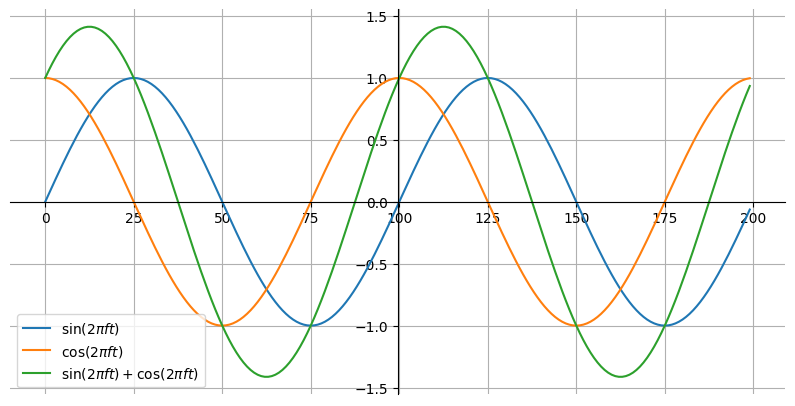

In [118]:
time = np.arange(0, 2, 0.01)

fig, axis = plt.subplots(1, 1, figsize=(10, 5))

axis.spines[['left', 'bottom']].set_position('center')
axis.spines[['top', 'right']].set_visible(False)

axis.grid()
axis.plot(np.sin(2 * np.pi * time), label=r'$\sin(2 \pi ft)$')
axis.plot(np.cos(2 * np.pi * time), label=r'$\cos(2 \pi ft)$')
axis.plot(np.sin(2 * np.pi * time) + np.cos(2 * np.pi * time), label=r'$\sin(2 \pi ft) + \cos(2 \pi ft)$')

axis.legend()

Adding cosine and sine waves result in a new pure sine wave with a different phase and amplitude. To transmit an IQ signal, it would look like:

$$x(t) = I\cos(2 \pi ft) + Q\sin(2 \pi ft)$$

### Complex Numbers
IQ is just different way of represeneting magnitude and phase. Think of a complex number as a vector instead of a point, the **magnitude** is the distance between the point and the origin, and the **phase** is the degree $\theta$ between the vector and the 0 degress. Look at the Phasor Diagram below:

magnitude &rarr; $\sqrt{a^2 + b^2 } = 0.806$  
  
phase &rarr; $\tan^{-1}(\frac{b}{a}) = -0.519 \ radians$

<p align="center">
  <img src="./assets/phasor_plot.png" />
</p>

### Transmitter and Receiver
To trasmit the point $0.7-0.4j$ the signal would be $$x(t) = 0.7\cos(2 \pi ft) - 0.4\sin(2 \pi ft)$$
Using the trig indentity $a\cos(x) + b\sin(x) = A\cos(x - \phi)$, where $A$ is the magnitude and $\phi$ is the phase, the equation above becomes: 
$$x(t) = 0.806\cos(2 \pi ft + 0.519)$$

In the receiver, the I and Q parts are usually sampled separately by two ADCs and then they are paired to create complex samples.

### Carrier and Downconvertion
Again, this is what signals being transmitted look like. $x(t) = I\cos(2 \pi ft) + Q\sin(2 \pi ft)$. The $f$ stands for **carrier frequency**.

Radio signals such FM, WiFi, GPS use carrier frequencies betwenn 100MHz - 6GHz. **Downconversion** is used to remove the carrier frequency before the contents of the signal are sampled. For example, if the signal from a WiFi antenna is connected to a single ADC, and the carrier frequency is 2.4GHz, then the ADC would have to sample the signal at least at 4.8GHz. That would be a costly ADC.

Instead, the signal is downcoverted to around 0Hz (DC). Then the maximun frequency isn't 2.4GHz but it would be based on the signal's characteristics (most signals are around 100kHz to 40MHz wide in bandwidth)

> Downconvertion and Upconversion is mostly done by a **Mixer**
    The mixer is the symbol circle with an X. It has 3 ports, input signal, output signal, and a connection to an oscillator.
    The frequency of the oscillator determines the frequency shift of the input signal. Remember that a Mixer is just a multiplication function and multiplying a sine wave shifts its frequency.

**Wavelenght** is the distance a wave travels in a single oscillation (a full cycle). $$f = \frac{c}{\lambda}$$
$c$ is the speed of light (~$3e8$), $f$ is the frequency is Hz, and wavelegnth $\lambda$ is in meters.


## Baseband and Bandpass Signals
A signal that is centered around 0Hz is at **baseband**. **Bandpass** refers to when a signal is at a RF frequency far from baseband because it was shifted up for the purpose of wireless transmission.

**Intermediate Frequency** is an intermediate conversion step within baseband and bandpass.

> baseband signals are often complex while bandpass signals are real, complex/imaginary signals can't be transmitted over RF
    A signal is complex if the negative and positve portions of the signals are not the same, complex numbers are used to represent negative frequencies.

> There are not negative frequencies, just a portion of the signal is at a lower frequency than the carrier frequency

It is better to create, recond, and analyze signals at baseband because you can work with them at a lower sample rate. 

### Calculate the Average Power
by taking the magnitude of each sample, squaring it and finding the mean. $$P=\frac{1}{N}\sum_{n=1}^{N}{\left|x[n]\right|^2}$$

and magnitude is just $\sqrt{I^2 + Q^2}$.

The **Power Spectral Density** on the other hand requires to get the frequency domain of the signal using an FFT.

1. Take the FFT of the samples. The FFT size will be the length of the samples by default. Maybe apply a window
    ```py
    Fs = 1e6 # lets say we sampled at 1 MHz
    # assume x contains your array of IQ samples
    N = 1024
    x = x[0:N] # we will only take the FFT of the first 1024 samples, see text below
    x = x np.hamming(len(x)) # apply window
    X = np.fft.fft(x) # take FFT
    ```

2. Get the magnitude of teh FFT Output, which provides the length of the samples with datatype float
3. Square the magnitudes to get the power
4. Normalize by dividing by the FTT size and the sample rate
    ```py
    # steps 2 - 4
    PSD = np.abs(X)**2 / (N * Fs)
    ```

5. Conver to dB by using $10\log_{10}()$ since the PSD is always viewed in a log scale
    ```py
    PSD_log = 10.0 * np.log10(PSD)
    ```

6. Perform an FFT Shift
    ```py
    PSD_shifted= np.fft.fftshift(PSD_log)
    ```

To find the PSD of millions of samples, a million-point FFT would take forever, instead do multiple PSDs and average them together.

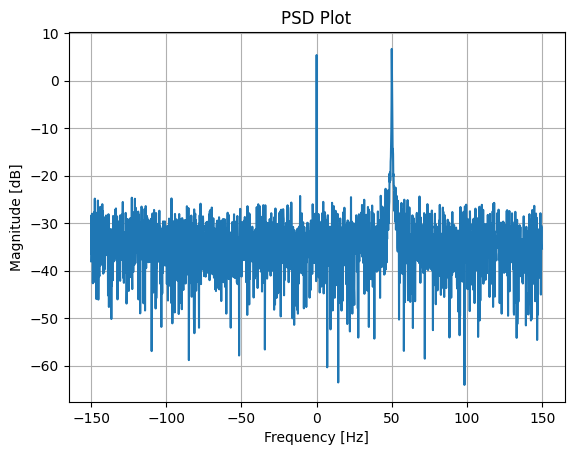

In [119]:
sample_rate = 300
frequency = 1 / sample_rate
num_samples = 2048

time = frequency * np.arange(num_samples)
signal = np.exp(1j * 2 * np.pi * 50 * time)
noise = (np.random.rand(num_samples) + 1j * np.random.rand(num_samples)) / np.sqrt(2)
noiser_power = 2

total_signal = signal + noise * np.sqrt(noiser_power)

PSD = np.abs(np.fft.fft(total_signal)) **2 / (sample_rate  * num_samples)
PSD_log = 10.0 * np.log10(PSD)
PSD_shifted = np.fft.fftshift(PSD_log)

res = np.arange(sample_rate / -2.0, sample_rate / 2.0, sample_rate / num_samples)

fig, axis = plt.subplots(1, 1)
axis.plot(res, PSD_shifted)
axis.set(title='PSD Plot', xlabel='Frequency [Hz]', ylabel='Magnitude [dB]')
axis.grid()


## Noise
**Gaussian Noise** is minimal noise, it usally averages to near zero in a time domain, and larger noise values are rare, most of them are near to zero. It is a good model for noise from natural resources such as thermal vibrations in atoms in the receiver's RF components.

When a lot of random things happen and accumulate, the result is usually Guassian, the **Guassian distribution** is also called the *normal* distribution, appears as bell curve.

There are two parameters to this distribution:
* Mean: the average can be considered zero
    * if the average isn't zero, then it's called **bias** an it can be subtracted so the average is zero

* Variance: how strong the noise is, higher variance results in larger noise.

### Decibels (dB)
Working with decibels is useful when working with small and large numbers at the same time. For a given value x, it can be represented in dB using: $$x_{dB} = 10\log_{10}x$$

or in python
```py
x_db = 10.0 * np.log10(10)
```

> note: in other domains, the 10.0 can be a 20.0 when dealing with non-power such as voltage or current

#### cheatsheet

dBW &rarr; relative to 1 Watt
dBm / dBmW &rarr; relative to 1 mW
0 dBm = -30 dBW

| **Linear** | **dB** |
|---|---|
| 1x | 0 dB |
| 2x | 3 dB |
| 10x | 10 dB |
| 0.5x | -3 dB |
| 0.1x | -10 dB |
| 100x | 10 dB |
| 1000x | 30 dB |
| 10000x | 40 dB |

### Complex Noise
When the signal is at baseband, the signal will experience *complex gaussian noise* and the noise power is split between the real and imaginary parts equally, but the real and imaginary parts are independent of each other, so knowing the values of one doesn't give you the value of another.


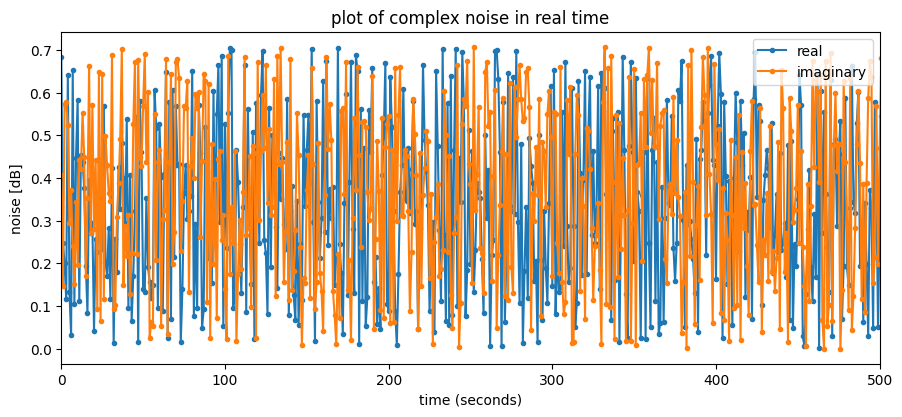

In [120]:
fig, axis = plt.subplots(1, 1, figsize=(10, 5))
fig.tight_layout(pad=5)

axis.plot(np.real(noise), '.-', label='real')
axis.plot(np.imag(noise), '.-', label='imaginary')
axis.set(xlim=(0, 500), xlabel='time (seconds)', ylabel='noise [dB]', title='plot of complex noise in real time')
axis.legend()

## Signal-to-Noise Ratio (SNR)
SNR is the difference in strength between signal and noise, it is measurement in dB.

$$\text{SNR} = \frac{P_{signal}}{P_{noise}}$$
$$\text{SNR}_{\text{dB}} = P_{signal_dB} - P_{noise_dB}$$

If the SNR is 0 dB then the signal and noise power are the same. Positive SNR means that the signal is higher power than the noise, and negative means that noise is stronger.
**Signal-to-Interferance-plus-Noise Ratio (SINR)** is the same as SNR except that interferance is included along with noise.
$$\text{SINR} = \frac{P_{signal}}{P_{interferance} + P_{noise}}$$
